In [40]:

import pandas as pd

from utils.io import yaml_to_dict
from projects.lobbying.postproc_utils import terms_present
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


### Load postprocessed data, summarize general counts

In [68]:
df = pd.read_csv(
    "/Volumes/Samsung_T5/data/lobbying/ccs/oct15_postprocessed_filings.csv"
)

df[
    [
        "ccs_company",
        "contains_description",
        "ccs_bills",
        "ccs_bills_number_only",
        "bills_with_ccs_terms",
        "definitely_ccs",
        "very_likely_ccs",
        "likely_ccs",
        "h2_mention_core_ff",
        "potentially_ccs",
    ]
].sum()

ccs_company                958
contains_description      8945
ccs_bills                 3304
ccs_bills_number_only     3920
bills_with_ccs_terms      3550
definitely_ccs           13050
very_likely_ccs          14513
likely_ccs               14938
h2_mention_core_ff        2168
potentially_ccs          30991
dtype: int64

### Summarize the mapping of names of organizations used on filing documents to single names 
(e.g. "EXXON MOBIL CORPORATION" and "EXXONMOBIL" are both mapped to "EXXONMOBIL")

In [69]:
companies_df = (
    df[
        [
            "client_name_on_filing_document",
            "client_id",
            "organization",
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "definitely_ccs",
        ]
    ]
    .groupby(["client_name_on_filing_document", "client_id"])
    .agg(
        {
            "definitely_ccs": "max",
            "organization": "first",
            "sector": "first",
            "lumped_sector": "first",
            "very_lumped_sector": "first",
        }
    )
)
companies_df.reset_index(inplace=True)
companies_df.sort_values(
    by=["organization", "client_name_on_filing_document", "client_id"], ascending=True
).to_clipboard()

### Subset data to lobbying activities identified as 'definitey CCS'. Compute percentages of total dollars and lobbying/entity contacts

In [70]:
# for plotting and analysis, subset to only the 'definitely ccs' lobbying activities
df = df.loc[df.definitely_ccs == 1]

tot_dollars = df.lobbying_activity_usd.sum()

tot_contacts = df.n_entities_lobbied.sum()

tot_dollars_since_2019 = df.loc[df.filing_year > 2018].lobbying_activity_usd.sum()

tot_contacts_since_2019 = df.loc[df.filing_year > 2018].n_entities_lobbied.sum()

# compute percentages of total dollars and entity contacts for all years
df["pct_of_lobbying_dollars_definitely_ccs"] = [
    100 * x / tot_dollars for x in df.lobbying_activity_usd
]

df["pct_of_entity_contacts_definitely_ccs"] = [
    100 * x / tot_contacts for x in df.n_entities_lobbied
]

# compute percentages of total dollars and entity contacts since 2019
df["pct_of_lobbying_dollars_definitely_ccs_since_2019"] = [
    100 * x / tot_dollars_since_2019 if y > 2018 else 0
    for x, y in zip(df.lobbying_activity_usd, df.filing_year)
]

df["pct_of_entity_contacts_definitely_ccs_since_2019"] = [
    100 * x / tot_contacts_since_2019 if y > 2018 else 0
    for x, y in zip(df.n_entities_lobbied, df.filing_year)
]

In [71]:
print("Dollars spent:")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].lobbying_activity_usd.sum()
print(f"From Jan 1 2019 through June 30 2024 ${since_2019:.0f}")
allyears = df.loc[(df.definitely_ccs == 1)].lobbying_activity_usd.sum()
print(f"From Jan 1 2005 through June 30 2024: ${allyears:.0f}")
print("")
print("Contacts made:")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].n_entities_lobbied.sum()
print(f"From Jan 1 2019 through June 30 2024: {since_2019}")
allyears = df.loc[(df.definitely_ccs == 1)].n_entities_lobbied.sum()
print(f"From Jan 1 2005 through June 30 2024: {allyears}")
print("")
print(
    f"CCS lobbying contacts per work day since start of 2019: {since_2019 / (50 * 5 * 5.5):.1f}"
)

Dollars spent:
From Jan 1 2019 through June 30 2024 $429157539
From Jan 1 2005 through June 30 2024: $755652202

Contacts made:
From Jan 1 2019 through June 30 2024: 34118
From Jan 1 2005 through June 30 2024: 57938

CCS lobbying contacts per work day since start of 2019: 24.8


In [72]:
core_ff_sectors = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/definitions/ccs_postproc_specifications.yml"
)["core_ff_sectors"]
ff_adjacent_sectors = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/definitions/ccs_postproc_specifications.yml"
)["ff_adjacent_sectors"]
pct_core_ff = df.loc[
    df.sector.isin(core_ff_sectors) & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
pct_ff_adjacent = df.loc[
    df.sector.isin(ff_adjacent_sectors) & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
pct_non_ff_industry = df.loc[
    (df.very_lumped_sector == "NON-FF-INDUSTRY") & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
print(
    f"Core fossil-fuel-sector industry is responsible for {pct_core_ff:.0f}% of CCS lobbying dollars"
)
print(
    f"Core FF + FF-adjacent industry is responsible for {pct_ff_adjacent:.0f}% of CCS lobbying dollars"
)
print(
    f"Non-fossil-fuel-sector industry is responsible for {pct_non_ff_industry:.0f}% of CCS lobbying dollars"
)
ratio_of_ff_to_non_ff_industry_spending = pct_core_ff / pct_non_ff_industry
print(
    f"Industry that directly profits from selling or burning fossil fuels spends {ratio_of_ff_to_non_ff_industry_spending:.0f} times as much as non-FF industry on CCS lobbying"
)

Core fossil-fuel-sector industry is responsible for 76% of CCS lobbying dollars
Core FF + FF-adjacent industry is responsible for 88% of CCS lobbying dollars
Non-fossil-fuel-sector industry is responsible for 3% of CCS lobbying dollars
Industry that directly profits from selling or burning fossil fuels spends 24 times as much as non-FF industry on CCS lobbying


In [22]:
pct_core_ff = df.loc[
    df.sector.isin(core_ff_sectors) & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
pct_ff_adjacent = df.loc[
    df.sector.isin(ff_adjacent_sectors) & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
pct_non_ff_industry = df.loc[
    (df.very_lumped_sector == "NON-FF-INDUSTRY") & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
print(
    f"Core fossil-fuel-sector industry is responsible for {pct_core_ff:.0f}% of CCS lobbying contacts"
)
print(
    f"Core FF + FF-adjacent industry is responsible for {pct_ff_adjacent:.0f}% of CCS lobbying contacts"
)
print(
    f"Non-fossil-fuel-sector industry is responsible for {pct_non_ff_industry:.0f}% of CCS lobbying contacts"
)
ratio_of_ff_to_non_ff_industry_spending = pct_core_ff / pct_non_ff_industry
print(
    f"Industry that directly profits from selling or burning fossil fuels contacts the federal government {ratio_of_ff_to_non_ff_industry_spending:.0f} times as much as non-FF industry on CCS lobbying"
)

Core fossil-fuel-sector industry is responsible for 56% of CCS lobbying contacts
Core FF + FF-adjacent industry is responsible for 74% of CCS lobbying contacts
Non-fossil-fuel-sector industry is responsible for 6% of CCS lobbying contacts
Industry that directly profits from selling or burning fossil fuels contacts the federal government 10 times as much as non-FF industry on CCS lobbying


In [73]:
for c in core_ff_sectors:
    print(f"{c.title()}")

print("")
for c in ff_adjacent_sectors:
    print(f"{c.title()}")

Oil And Gas
Investor Owned Utilities
Chemicals, Refining, And Plastics
Coal
Ccs
Independent Power Producers
Pipelines
Municipal And Cooperative Utilities
Power Sector General
Oilfield Services
Clean Hydrogen

Oil And Gas
Investor Owned Utilities
Chemicals, Refining, And Plastics
Coal
Biofuels
Energy Technology
Ccs
Independent Power Producers
Power Sector General
Air Transit
Railway
Pipelines
Municipal And Cooperative Utilities
Business Advocacy
Fuel Cell
Land Transit
Oilfield Services
Clean Hydrogen


### Which lumped sectors do the most CCS lobbying?

In [74]:
lobbying_by_sector_totals_df = (
    df[
        [
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "pct_of_lobbying_dollars_definitely_ccs",
            "pct_of_entity_contacts_definitely_ccs",
        ]
    ]
    .loc[df["definitely_ccs"] == 1]
    .groupby(["lumped_sector"])
    .agg(
        {
            # "lumped_sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
            "pct_of_lobbying_dollars_definitely_ccs": sum,
            "pct_of_entity_contacts_definitely_ccs": sum,
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)


lobbying_by_sector_totals_df  # .to_clipboard()

,very_lumped_sector,lobbying_activity_usd,n_entities_lobbied,pct_of_lobbying_dollars_definitely_ccs,pct_of_entity_contacts_definitely_ccs
lumped_sector,,,,,
FOSSIL FUEL,FOSSIL-FUEL,2.584012e+08,14796,34.195791,25.537644
INVESTOR-OWNED-POWER-SECTOR,POWER-UTILITIES,2.351881e+08,9664,31.123855,16.679899
CHEMICALS,CHEMICALS,5.521131e+07,3982,7.306445,6.872864
TRANSPORT,TRANSPORT,3.505637e+07,2832,4.639221,4.887984
NON-FF-INDUSTRY,NON-FF-INDUSTRY,2.406134e+07,3201,3.184182,5.524871
BIOFUEL-SYNFUEL,BIOFUEL-SYNFUEL,2.053750e+07,3892,2.717851,6.717526
ENGINEERING-TECH,ENGINEERING-TECH,2.010658e+07,3021,2.660825,5.214194
BUSINESS-ADVOCACY,BUSINESS-ADVOCACY,1.891113e+07,1480,2.502623,2.554455
MUNICIPAL-UTILITIES,POWER-UTILITIES,1.660016e+07,1462,2.196799,2.523387


### Which organizations do the most lobbying for CCS?

In [91]:
df[["organization", "lobbying_activity_usd"]].groupby(
    ["organization"]
).sum().sort_values(by=["lobbying_activity_usd"], ascending=False).head(20)

,lobbying_activity_usd
organization,
OCCIDENTAL PETROLEUM,6.943090e+07
SOUTHERN COMPANY,5.413127e+07
EXXONMOBIL,3.909727e+07
EDISON ELECTRIC INSTITUTE,2.764227e+07
AMERICAN ELECTRIC POWER,2.209047e+07
SHELL,2.048418e+07
CHEVRON,1.742338e+07
DUKE,1.666763e+07
BP AMERICA,1.495798e+07


### Which organizations in other sectors do the most CCS lobbying?

In [25]:
for sector in [
    "higher education",
    "think tanks and issue advocacy",
    "environmental",
    "finance",
    "independent research organization",
    "business advocacy",
]:
    ccs_sector_df = (
        df[["organization", "lobbying_activity_usd"]]
        .loc[df.sector == sector]
        .groupby(["organization"])
        .sum()
        .sort_values(by=["lobbying_activity_usd"], ascending=False)
    )
    display(ccs_sector_df)

,lobbying_activity_usd
organization,
UNIVERSITY OF PITTSBURGH,588869.047619
YALE UNIVERSITY,153142.857143
UNIVERSITY OF ILLINOIS,145105.050505
OHIO UNIVERSITY,78596.736597
UNIVERSITY OF TEXAS,73750.000000
UNIVERSITY OF MICHIGAN,72018.000920
CALIFORNIA INSTITUTE OF TECHNOLOGY,72000.000000
ASSOCIATION OF AMERICAN UNIVERSITIES,61819.047619
GEORGIA INSTITUTE OF TECHNOLOGY,56666.666667


,lobbying_activity_usd
organization,
BIPARTISAN POLICY CENTER,1.189484e+06
NATIONAL RIGHT TO WORK COMMITTEE,4.520000e+05
COALITION FOR ENERGY EFFICIENT JOBS INVESTMENT,3.000000e+05
CLEARPATH ACTION FOR CONSERVATIVE CLEAN ENERGY,2.000000e+05
ELECTRIFY AMERICA,1.050000e+05
CENTER FOR AMERICAN PROGRESS,6.285714e+04
CENTER FOR TRANSPORTATION AND ENVIRONMENT,6.000000e+04
AMERICANS FOR TAX REFORM,5.425000e+04
SECURING AMERICAS FUTURE ENERGY,3.716667e+04


,lobbying_activity_usd
organization,
CLEAN AIR TASK FORCE,2.231968e+06
NATURE CONSERVANCY,1.921032e+06
CITIZENS FOR RESPONSIBLE ENERGY SOLUTIONS,1.429333e+06
EARTHJUSTICE,6.229773e+05
ENVIRONMENTAL DEFENSE FUND,5.963580e+05
WILDERNESS SOCIETY,4.312894e+05
LINDEN TRUST FOR CONSERVATION,3.700000e+05
SIERRA CLUB,3.609724e+05
SOUTHERN ENVIRONMENTAL LAW CENTER,3.533571e+05


,lobbying_activity_usd
organization,
ZURICH,2.082202e+06
BREAKTHROUGH ENERGY,2.075286e+06
NATIONAL VENTURE CAPITAL ASSOCIATION,1.500079e+06
NATIONAL ASSOCIATION OF FEDERALLYINSURED CREDIT UNIONS,1.020000e+06
LEUCADIA NATIONAL,2.200000e+05
ARTHUR J GALLAGHER,1.450000e+05
BANK OF AMERICA,9.714286e+04
BANK POLICY INSTITUTE,6.000000e+04
MACQUARIE INFRASTRUCTURE AND REAL ASSETS,3.000000e+04


,lobbying_activity_usd
organization,
GREAT PLAINS INSTITUTE,326333.333333
WORLD RESOURCES INSTITUTE,180000.000000
WOODWELL CLIMATE RESEARCH CENTER,10000.000000
RTI INTERNATIONAL,4000.000000


,lobbying_activity_usd
organization,
US CHAMBER OF COMMERCE,1.444592e+07
NATIONAL ASSOCIATION OF MANUFACTURERS,3.809658e+06
BUSINESS ROUNDTABLE,4.175000e+05
GREATER PITTSBURGH CHAMBER OF COMMERCE,1.363810e+05
WESTERN BUSINESS ROUNDTABLE,1.016667e+05


### Excel Table of sector totals, including since 2019

In [26]:
# subset data looking only at definitely ccs and that occuring 2019 and later
since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["sector"])
    .agg(
        {
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
since_2019_df.columns = [
    "General sector",
    "total_ccs_lobbying_usd_2019_to_mid_2024",
    "total_ccs_lobbying_contacts_2019_to_mid_2024",
]
# get all years' data
total_df = (
    df[
        [
            "sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["sector"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
total_df.columns = [
    "total_ccs_lobbying_usd_2005_to_mid2024",
    "total_ccs_lobbying_contacts_2005_to_mid2024",
]
# summarize, grouping by detailed sector
sector_summary_df = since_2019_df.merge(total_df, left_index=True, right_index=True)
sector_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2019_to_mid_2024", ascending=False, inplace=True
)
sector_summary_df = sector_summary_df[
    [
        "General sector",
        "total_ccs_lobbying_usd_2019_to_mid_2024",
        "total_ccs_lobbying_usd_2005_to_mid2024",
        "total_ccs_lobbying_contacts_2019_to_mid_2024",
        "total_ccs_lobbying_contacts_2005_to_mid2024",
    ]
].to_clipboard()

### Excel Table of lobbying dollars and contacts by year and quarter (filing period)

In [27]:
# Table of temporal totals (by quarters)
numeric_quarter_dict = {
    "first_quarter": 1,
    "second_quarter": 2,
    "fourth_quarter": 4,
    "third_quarter": 3,
    "year_end": 4,
    "mid_year": 2,
}
df["numeric_filing_period"] = [numeric_quarter_dict[x] for x in df.filing_period]


through_time_df = (
    df[
        [
            "filing_year",
            "numeric_filing_period",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["filing_year", "numeric_filing_period"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
    .reset_index()
)
through_time_df.columns = [
    "filing_year",
    "filing_period",
    "total_ccs_lobbying_usd",
    "total_ccs_lobbying_contacts",
]
through_time_df.sort_values(
    by=["filing_year", "filing_period"], ascending=True, inplace=True
)
through_time_df.to_clipboard()

### Excel Table of organization totals, including since 2019

In [28]:
# subset data looking only at definitely ccs and that occuring 2019 and later
since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .agg(
        {
            "sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
since_2019_df.columns = [
    "Detailed sector",
    "General sector",
    "total_ccs_lobbying_usd_2019_to_mid_2024",
    "total_ccs_lobbying_contacts_2019_to_mid_2024",
]
# total for all years
total_df = (
    df[
        [
            "filing_year",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["organization"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
total_df.columns = [
    "total_ccs_lobbying_usd_2005_to_mid2024",
    "total_ccs_lobbying_contacts_2005_to_mid2024",
]

company_summary_df = since_2019_df.merge(total_df, left_index=True, right_index=True)
company_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2019_to_mid_2024", ascending=False, inplace=True
)
company_summary_df = company_summary_df[
    [
        "General sector",
        "Detailed sector",
        "total_ccs_lobbying_usd_2019_to_mid_2024",
        "total_ccs_lobbying_usd_2005_to_mid2024",
        "total_ccs_lobbying_contacts_2019_to_mid_2024",
        "total_ccs_lobbying_contacts_2005_to_mid2024",
    ]
].to_clipboard()

### Summarize lobbying-count and dollars spent for all organizations

In [34]:
total_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
        ]
    ]
    .loc[df.definitely_ccs == 1]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .sum()
)
since_2019_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .sum()
)
print(" *** All organizations, 2005-2024 ***")
print(total_series)
print("")
print(" *** All organizations, 2019-2024 ***")
print(since_2019_series)

 *** All organizations, 2005-2024 ***
lobbying_activity_usd                    7.556522e+08
n_entities_lobbied                       5.793800e+04
legistlative_entities_lobbied            2.678000e+04
executive_entities_lobbied               3.115800e+04
energy, dept of                          4.752000e+03
environmental protection agency (epa)    3.226000e+03
dtype: float64

 *** All organizations, 2019-2024 ***
lobbying_activity_usd                    4.291575e+08
n_entities_lobbied                       3.411800e+04
legistlative_entities_lobbied            1.667100e+04
executive_entities_lobbied               1.744700e+04
energy, dept of                          2.840000e+03
environmental protection agency (epa)    1.648000e+03
dtype: float64


### Summarize lobbying-count and dollars spent for the 'heavy hitting' organizations (responsible for 50 percent of federal CCS lobbying)

In [30]:
# get all-organization totals for past 20 years and past 5: find the number of organizations responsible for 50 percent of lobbying
total_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[df.definitely_ccs == 1]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(18)
    .sum()
)
since_2019_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs_since_2019",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(22)
    .sum()
)
print(" *** Heavy-hitting organizations, 2005-2024 ***")
print(total_series)
print("")
print(" *** Heavy-hitting organizations, 2019-2024 ***")
print(since_2019_series)

 *** Heavy-hitting organizations, 2005-2024 ***
lobbying_activity_usd                     3.778507e+08
pct_of_lobbying_dollars_definitely_ccs    5.000325e+01
n_entities_lobbied                        1.300300e+04
energy, dept of                           1.022000e+03
environmental protection agency (epa)     9.960000e+02
legistlative_entities_lobbied             5.061000e+03
executive_entities_lobbied                7.942000e+03
dtype: float64

 *** Heavy-hitting organizations, 2019-2024 ***
lobbying_activity_usd                                2.127510e+08
pct_of_lobbying_dollars_definitely_ccs_since_2019    4.957411e+01
n_entities_lobbied                                   7.612000e+03
energy, dept of                                      5.890000e+02
environmental protection agency (epa)                4.900000e+02
legistlative_entities_lobbied                        2.972000e+03
executive_entities_lobbied                           4.640000e+03
dtype: float64


### Summary figure: definite CCS lobbying by sector, through time

Text(0.5, 1.0, 'Dollars spent lobbying the US Federal Government regarding CCS')

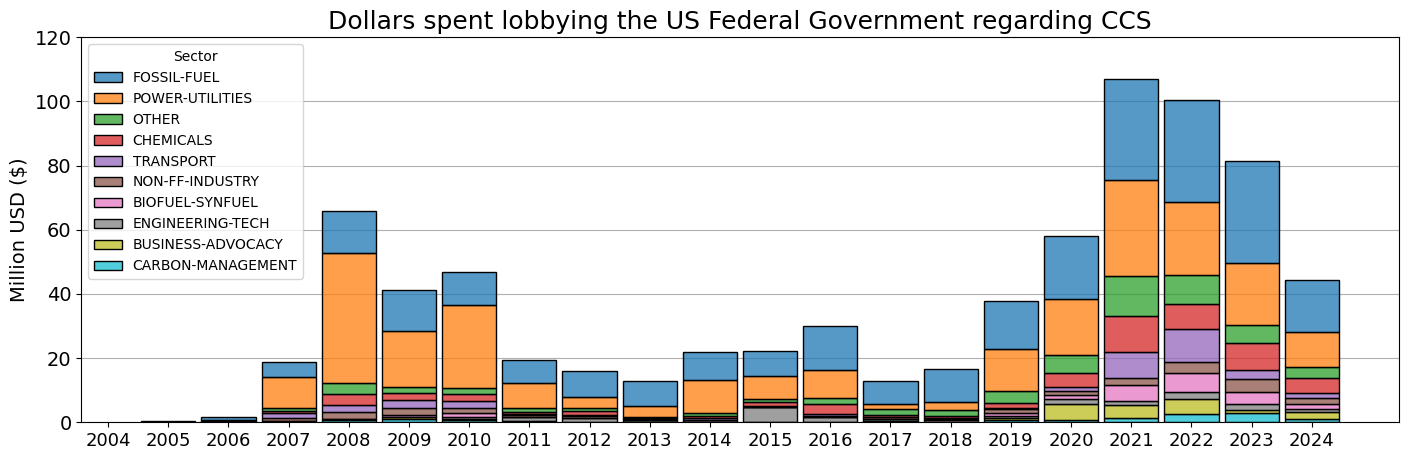

In [99]:
# for histogram hue ordering:
sector_for_group = "very_lumped_sector"
very_lumped_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_df.rename(columns={"very_lumped_sector": "Sector"}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="Sector",
    hue_order=very_lumped_order,
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette="tab10",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=13)
ax.set_yticks([0.0e8, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8, 1.2e8])
ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120], fontsize=14)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("Million USD ($)", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")
ax.set_title(
    "Dollars spent lobbying the US Federal Government regarding CCS", fontsize=18
)

### Figure showing major CCS lobbiers lobbying dollars spent through time

Text(0.5, 0, '')

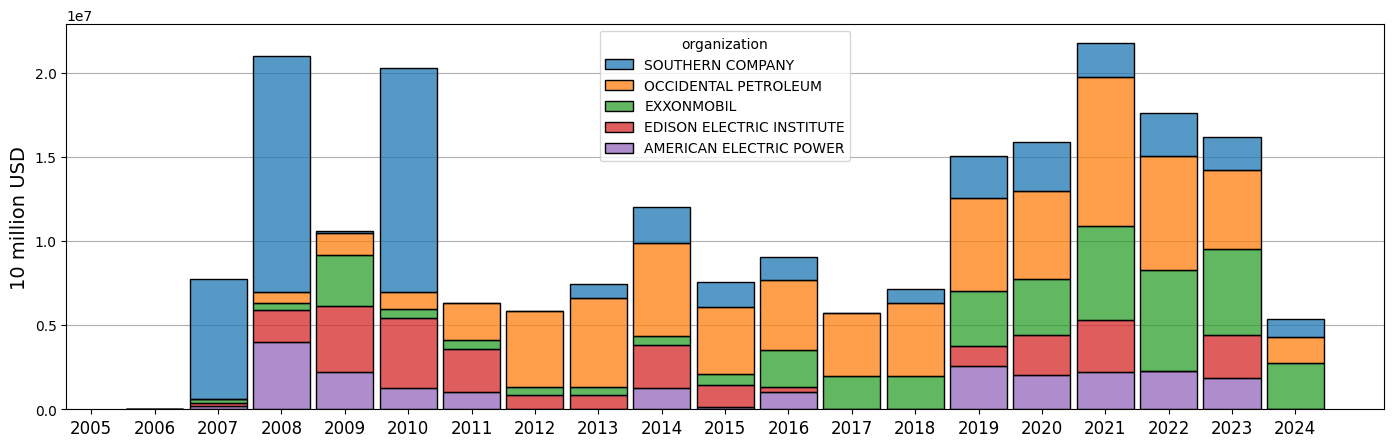

In [33]:
top_10 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
    "US CHAMBER OF COMMERCE",
    "SHELL",
    "DUKE",
    "BP AMERICA",
    "CHEVRON",
]
top_3 = ["EXXONMOBIL", "OCCIDENTAL PETROLEUM", "SOUTHERN COMPANY"]
top_5 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
]
top_df = (
    df[["lobbying_activity_usd", "n_entities_lobbied", "organization", "filing_year"]]
    .loc[(df.very_likely_ccs == 1) & (df.organization.isin(top_5))]
    .groupby(["filing_year", "organization"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)

years = list(range(2005, 2025))

fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=top_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="organization",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("10 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")

### Quantify steel industry's environmental lobbying that *DOESNT* relate to CCS

In [41]:
steel_df = pd.read_csv(
    "/Volumes/Samsung_T5/data/lobbying/steel_iron_organizations/oct9_postprocessed_steel_iron_org_filings.csv"
)
print("We'll focus on activities that are not even potentially CCS activities: ")
steel_df.potentially_ccs.value_counts()

We'll focus on activities that are not even potentially CCS activities: 


potentially_ccs
0    5899
1     209
Name: count, dtype: int64

In [42]:
15.6 / 4.6

3.3913043478260874

In [43]:
# identify lobbying activities dealing with 'environmental' subjects
steel_df["environmental"] = [
    1
    if terms_present(
        x,
        [
            "environment",
            "sustainability",
            "sustain",
            "renewable",
            "climate",
            "net zero",
            "greenhouse",
            "paris accord",
            "low carbon",
            "carbon neutral",
            "carbon-neutral",
            "emission",
            "air quality",
            "recycle",
            "recycled",
            "recycling",
            "carbon dioxide",
            "solar",
            "wind",
            "clean air",
            "co2",
            "green hydrogen",
            "carbondioxide",
            "GHG",
            "pollution",
            "green steel",
            "pollutant",
            "green h2",
            "zero emission",
            "reduced carbon",
            "zero-emission",
            "zero carbon",
            "zerocarbon",
            "lowcarbon",
            "carbonneutral",
            "earth friendly",
            "cafe standard",
            "low waste",
        ],
    )
    else 0
    for x in steel_df.cleaned_description
]
steel_df.loc[steel_df.potentially_ccs == 0].environmental.value_counts()

environmental
0    4712
1    1187
Name: count, dtype: int64

In [44]:
total_non_ccs_enviornmental_dollars_steel = steel_df.loc[
    (steel_df.environmental == 1)
    & (steel_df.potentially_ccs == 0)
    & (steel_df.sector == "iron and steel")
].lobbying_activity_usd.sum()

print(
    f"The steel industry spent ${total_non_ccs_enviornmental_dollars_steel:.0f} between 2005 and 2024 lobbying regarding non-CCS environmental topics"
)

The steel industry spent $51593404 between 2005 and 2024 lobbying regarding non-CCS environmental topics


In [79]:
oil_df = pd.read_csv(
    "/Volumes/Samsung_T5/data/lobbying/oil_and_gas_orgs/oct16_postprocessed_filings.csv"
)
print("We'll focus on activities that are not even potentially CCS activities: ")
oil_df.potentially_ccs.value_counts()

We'll focus on activities that are not even potentially CCS activities: 


potentially_ccs
0    28446
1     4467
Name: count, dtype: int64

In [80]:
oil_df.lobbying_activity_usd.fillna(0, inplace=True)

In [81]:
oil_df.loc[
    (oil_df.organization == "ANADARKO") & (oil_df.definitely_ccs == 1)
].cleaned_activity_description.values

array([], dtype=object)

In [82]:
oil_df.loc[
    (oil_df.organization == "OCCIDENTAL PETROLEUM") & (oil_df.definitely_ccs == 1)
].lobbying_activity_usd.sum()

69430899.80586472

In [89]:
ccs_oil_lobbying_df = (
    oil_df[["organization", "lobbying_activity_usd"]]
    .loc[oil_df.definitely_ccs == 1]
    .groupby("organization")
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
ccs_oil_lobbying_df.columns = ["ccs_lobbying_activity_usd_2005_2024"]
total_oil_lobbying_df = (
    oil_df[["organization", "lobbying_activity_usd"]]
    .groupby("organization")
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
total_oil_lobbying_df.columns = ["all_lobbying_activity_usd_2005_2024"]
ccs_fraction_df = total_oil_lobbying_df.merge(
    ccs_oil_lobbying_df, left_index=True, right_index=True
)
ccs_fraction_df["ccs_fraction"] = [
    ccs / a if a > 0 else 0
    for ccs, a in zip(
        ccs_fraction_df["ccs_lobbying_activity_usd_2005_2024"],
        ccs_fraction_df["all_lobbying_activity_usd_2005_2024"],
    )
]
ccs_fraction_df = ccs_fraction_df[
    [
        "ccs_fraction",
        "all_lobbying_activity_usd_2005_2024",
        "ccs_lobbying_activity_usd_2005_2024",
    ]
].sort_values(by="ccs_lobbying_activity_usd_2005_2024", ascending=False)
ccs_fraction_df

,ccs_fraction,all_lobbying_activity_usd_2005_2024,ccs_lobbying_activity_usd_2005_2024
organization,,,
OCCIDENTAL PETROLEUM,0.344315,2.016495e+08,6.943090e+07
SOUTHERN COMPANY,0.180971,3.000145e+08,5.429379e+07
EXXONMOBIL,0.115523,3.410625e+08,3.940060e+07
SHELL,0.104097,1.984455e+08,2.065751e+07
CHEVRON,0.060424,2.969602e+08,1.794338e+07
BP AMERICA,0.091277,1.638745e+08,1.495798e+07
CONOCOPHILLIPS,0.059594,1.539807e+08,9.176293e+06
AMERICAN PETROLEUM INSTITUTE,0.050527,1.674759e+08,8.462077e+06
MARATHON,0.040506,1.391458e+08,5.636218e+06


### Same figure, but for Powerpoint

Text(0.5, 1.0, 'Dollars spent lobbying the US Federal Government regarding Carbon Capture and Storage')

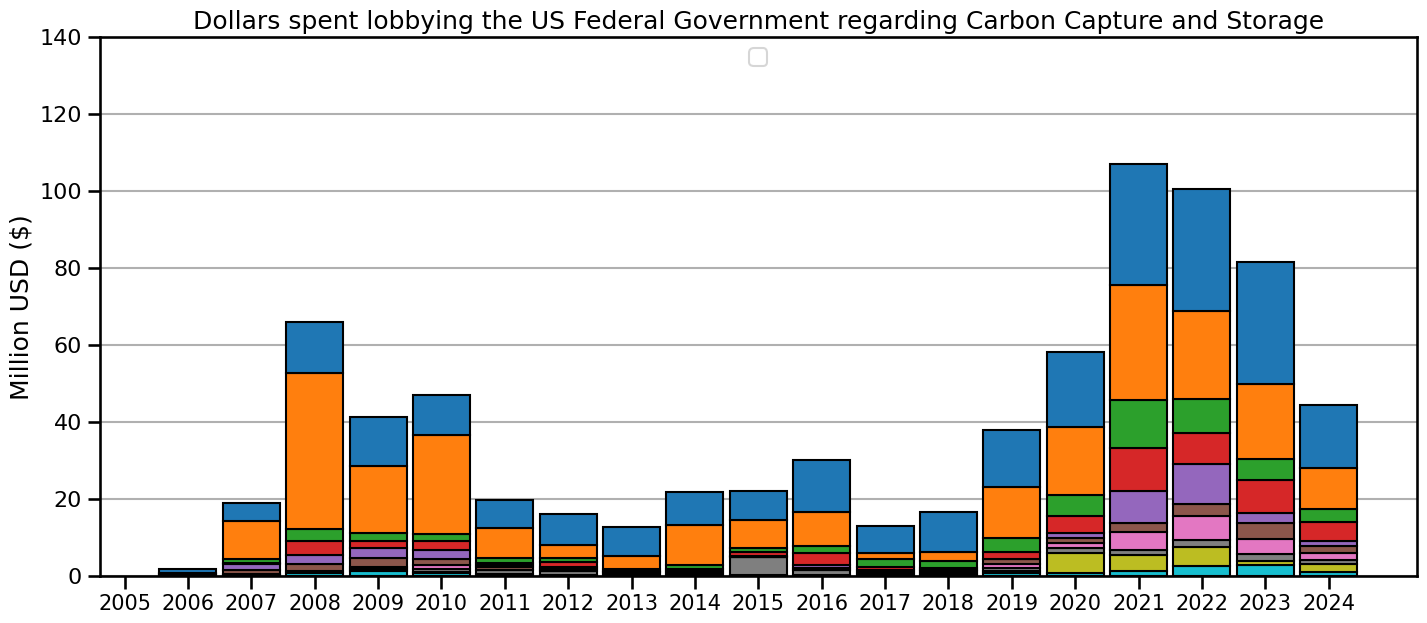

In [78]:
sns.set_context("talk")
# for histogram hue ordering:

very_lumped_order = list(
    df[["very_lumped_sector", "lobbying_activity_usd"]]
    .groupby("very_lumped_sector")
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2005, 2025))
tmp_df = df.copy(deep=True)
tmp_df.rename(columns={"very_lumped_sector": "Sector"}, inplace=True)
sector_for_group = "Sector"
tmp_df = (
    tmp_df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
)

fig, ax = plt.subplots(1, 1, figsize=(17, 7))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue=sector_for_group,
    hue_order=very_lumped_order,
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette="tab10",
    alpha=1,
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=15)
ax.set_yticks([0.0e8, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8, 1.2e8, 1.4e8])
ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120, 140], fontsize=16)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("Million USD ($)")  # , fontsize=14)
ax.set_xlabel("")
ax.set_title(
    "Dollars spent lobbying the US Federal Government regarding Carbon Capture and Storage"
)